In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_nodes = pd.read_csv("data/nodes.dat", delimiter = " ")
df_nodes.columns = ['nodeID', 'longitude', 'latitude']
df_nodes.head()

,nodeID,longitude,latitude
0,1,-121.902153,41.974766
1,2,-121.896790,41.988075
2,3,-121.889603,41.998032
3,4,-121.886681,42.008739
4,5,-121.915062,41.970314


In [3]:
df_edges = pd.read_csv("data/edges.dat", delimiter = " ")
df_edges.columns = ['edgeID', 'start node ID', 'end node ID', 'distance']
df_edges.head()

,edgeID,start node ID,end node ID,distance
0,1,0,6,0.005952
1,2,1,2,0.014350
2,3,2,3,0.012279
3,4,3,4,0.011099
4,5,5,6,0.006157


In [4]:
G = nx.Graph()

In [5]:
for i ,row in df_nodes.iterrows():
    G.add_node(int(row["nodeID"]), pos = (row["longitude"], row["latitude"]))

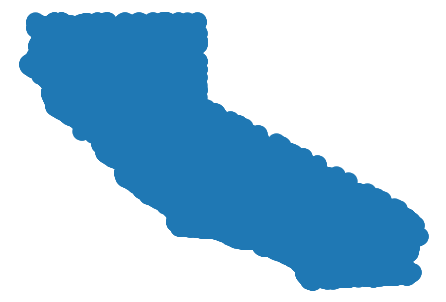

In [6]:
nx.draw(G, nx.get_node_attributes(G, 'pos'))